# Plot Synonym Tree Results

This notebook loads results from the synonym tree experiment and plots:
1. Generalization error vs training set size for each algorithm (color-coded by lambda)
2. Grid of all metrics for all algorithms


In [1]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import glob
import re
from collections import defaultdict

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)


In [2]:
# Configuration
experiment_dir = "/home/goring/NN_alternatecoding/outputs/synonym_tree_rhm_1911_big_20251119_031220"
algorithms = ["sgd_relu", "alt_em_sgd", "sgd_joint","alt_em_closed_form"]

print(f"Loading results from: {experiment_dir}")


Loading results from: /home/goring/NN_alternatecoding/outputs/synonym_tree_rhm_1911_big_20251119_031220


In [3]:
# Load all results
def parse_dir_name(dirname):
    """Parse n_train and lambda from directory name like 'n128_lam0' or 'n1024_lam1e-3'"""
    match = re.match(r'n(\d+)_lam(.+)', dirname)
    if match:
        n_train = int(match.group(1))
        lam_str = match.group(2)
        # Convert lambda string to float
        if lam_str == '0':
            lam = 0.0
        else:
            lam = float(lam_str)
        return n_train, lam
    return None, None

# Collect all data
data = defaultdict(lambda: defaultdict(dict))  # algo -> n_train -> lambda -> metrics

# Get all combination directories
combo_dirs = [d for d in os.listdir(experiment_dir) 
              if os.path.isdir(os.path.join(experiment_dir, d)) and d.startswith('n')]

for combo_dir in combo_dirs:
    n_train, lam = parse_dir_name(combo_dir)
    if n_train is None:
        continue
    
    combo_path = os.path.join(experiment_dir, combo_dir)
    
    for algo in algorithms:
        algo_path = os.path.join(combo_path, algo)
        metrics_path = os.path.join(algo_path, "final_metrics.json")
        
        if os.path.exists(metrics_path):
            try:
                with open(metrics_path, 'r') as f:
                    metrics = json.load(f)
                data[algo][n_train][lam] = metrics
            except Exception as e:
                print(f"Error loading {metrics_path}: {e}")

print(f"Loaded data for {len(data)} algorithms")
for algo in algorithms:
    n_train_counts = len(data[algo])
    print(f"  {algo}: {n_train_counts} training sizes")


Loaded data for 4 algorithms
  sgd_relu: 3 training sizes
  alt_em_sgd: 3 training sizes
  sgd_joint: 3 training sizes
  alt_em_closed_form: 3 training sizes


## Plot 1: Generalization Error vs Training Set Size (per algorithm)


In [4]:
# Get unique lambda values for color mapping
all_lambdas = set()
for algo in algorithms:
    for n_train in data[algo]:
        all_lambdas.update(data[algo][n_train].keys())
all_lambdas = sorted(all_lambdas)

# Create colormap
n_colors = len(all_lambdas)
cmap = plt.cm.get_cmap('viridis', n_colors)
lambda_to_color = {lam: cmap(i) for i, lam in enumerate(all_lambdas)}

print(f"Found {len(all_lambdas)} unique lambda values: {all_lambdas[:5]}...")
print(f"Color mapping: {dict(list(lambda_to_color.items())[:3])}")


Found 10 unique lambda values: [0.0, 0.0001, 0.001, 0.005, 0.01]...
Color mapping: {0.0: (np.float64(0.267004), np.float64(0.004874), np.float64(0.329415), np.float64(1.0)), 0.0001: (np.float64(0.281412), np.float64(0.155834), np.float64(0.469201), np.float64(1.0)), 0.001: (np.float64(0.244972), np.float64(0.287675), np.float64(0.53726), np.float64(1.0))}


/tmp/ipykernel_26081/808879806.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', n_colors)


In [5]:
# Plot generalization error (test_loss) vs training size for each algorithm
fig, axes = plt.subplots(1, len(algorithms), figsize=(6*len(algorithms), 5))
if len(algorithms) == 1:
    axes = [axes]

for idx, algo in enumerate(algorithms):
    ax = axes[idx]
    
    # Collect data for this algorithm
    for lam in all_lambdas:
        n_trains = []
        test_losses = []
        
        for n_train in sorted(data[algo].keys()):
            if lam in data[algo][n_train]:
                metrics = data[algo][n_train][lam]
                if 'test_loss' in metrics:
                    n_trains.append(n_train)
                    test_losses.append(metrics['test_loss'])
        
        if n_trains:
            # Format lambda for label
            if lam == 0:
                lam_label = '0'
            elif lam < 0.001:
                lam_label = f'{lam:.0e}'
            else:
                lam_label = f'{lam:.3f}'
            
            ax.plot(n_trains, test_losses, 'o-', color=lambda_to_color[lam], 
                   label=f'λ={lam_label}', linewidth=2, markersize=6, alpha=0.8)
    
    ax.set_xlabel('Training Set Size', fontsize=12)
    ax.set_ylabel('Generalization Error (Test Loss)', fontsize=12)
    ax.set_title(f'{algo}', fontsize=14, fontweight='bold')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(True, alpha=0.3)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9, ncol=1)

plt.tight_layout()
plt.savefig('generalization_error_by_algorithm.png', dpi=300, bbox_inches='tight')
plt.show()


KeyboardInterrupt: 

## Plot 2: Grid of All Metrics for All Algorithms


In [ ]:
# Define metrics to plot
metrics_to_plot = [
    ('test_loss', 'Test Loss', 'log'),
    ('test_mse', 'Test MSE', 'log'),
    ('val_loss', 'Val Loss', 'log'),
]

# Add slope metrics if available
slope_metrics = [
    ('final_slope_budget_total', 'Slope Budget', 'linear'),
    ('final_slope_entropy_total', 'Slope Entropy', 'linear'),
]

# Check if slope metrics exist
has_slope_metrics = False
for algo in algorithms:
    for n_train in data[algo].values():
        for metrics in n_train.values():
            if 'final_slope_budget_total' in metrics:
                has_slope_metrics = True
                break
        if has_slope_metrics:
            break
    if has_slope_metrics:
        break

if has_slope_metrics:
    metrics_to_plot.extend(slope_metrics)

n_metrics = len(metrics_to_plot)
n_algorithms = len(algorithms)

print(f"Plotting {n_metrics} metrics for {n_algorithms} algorithms")


Plotting 5 metrics for 4 algorithms


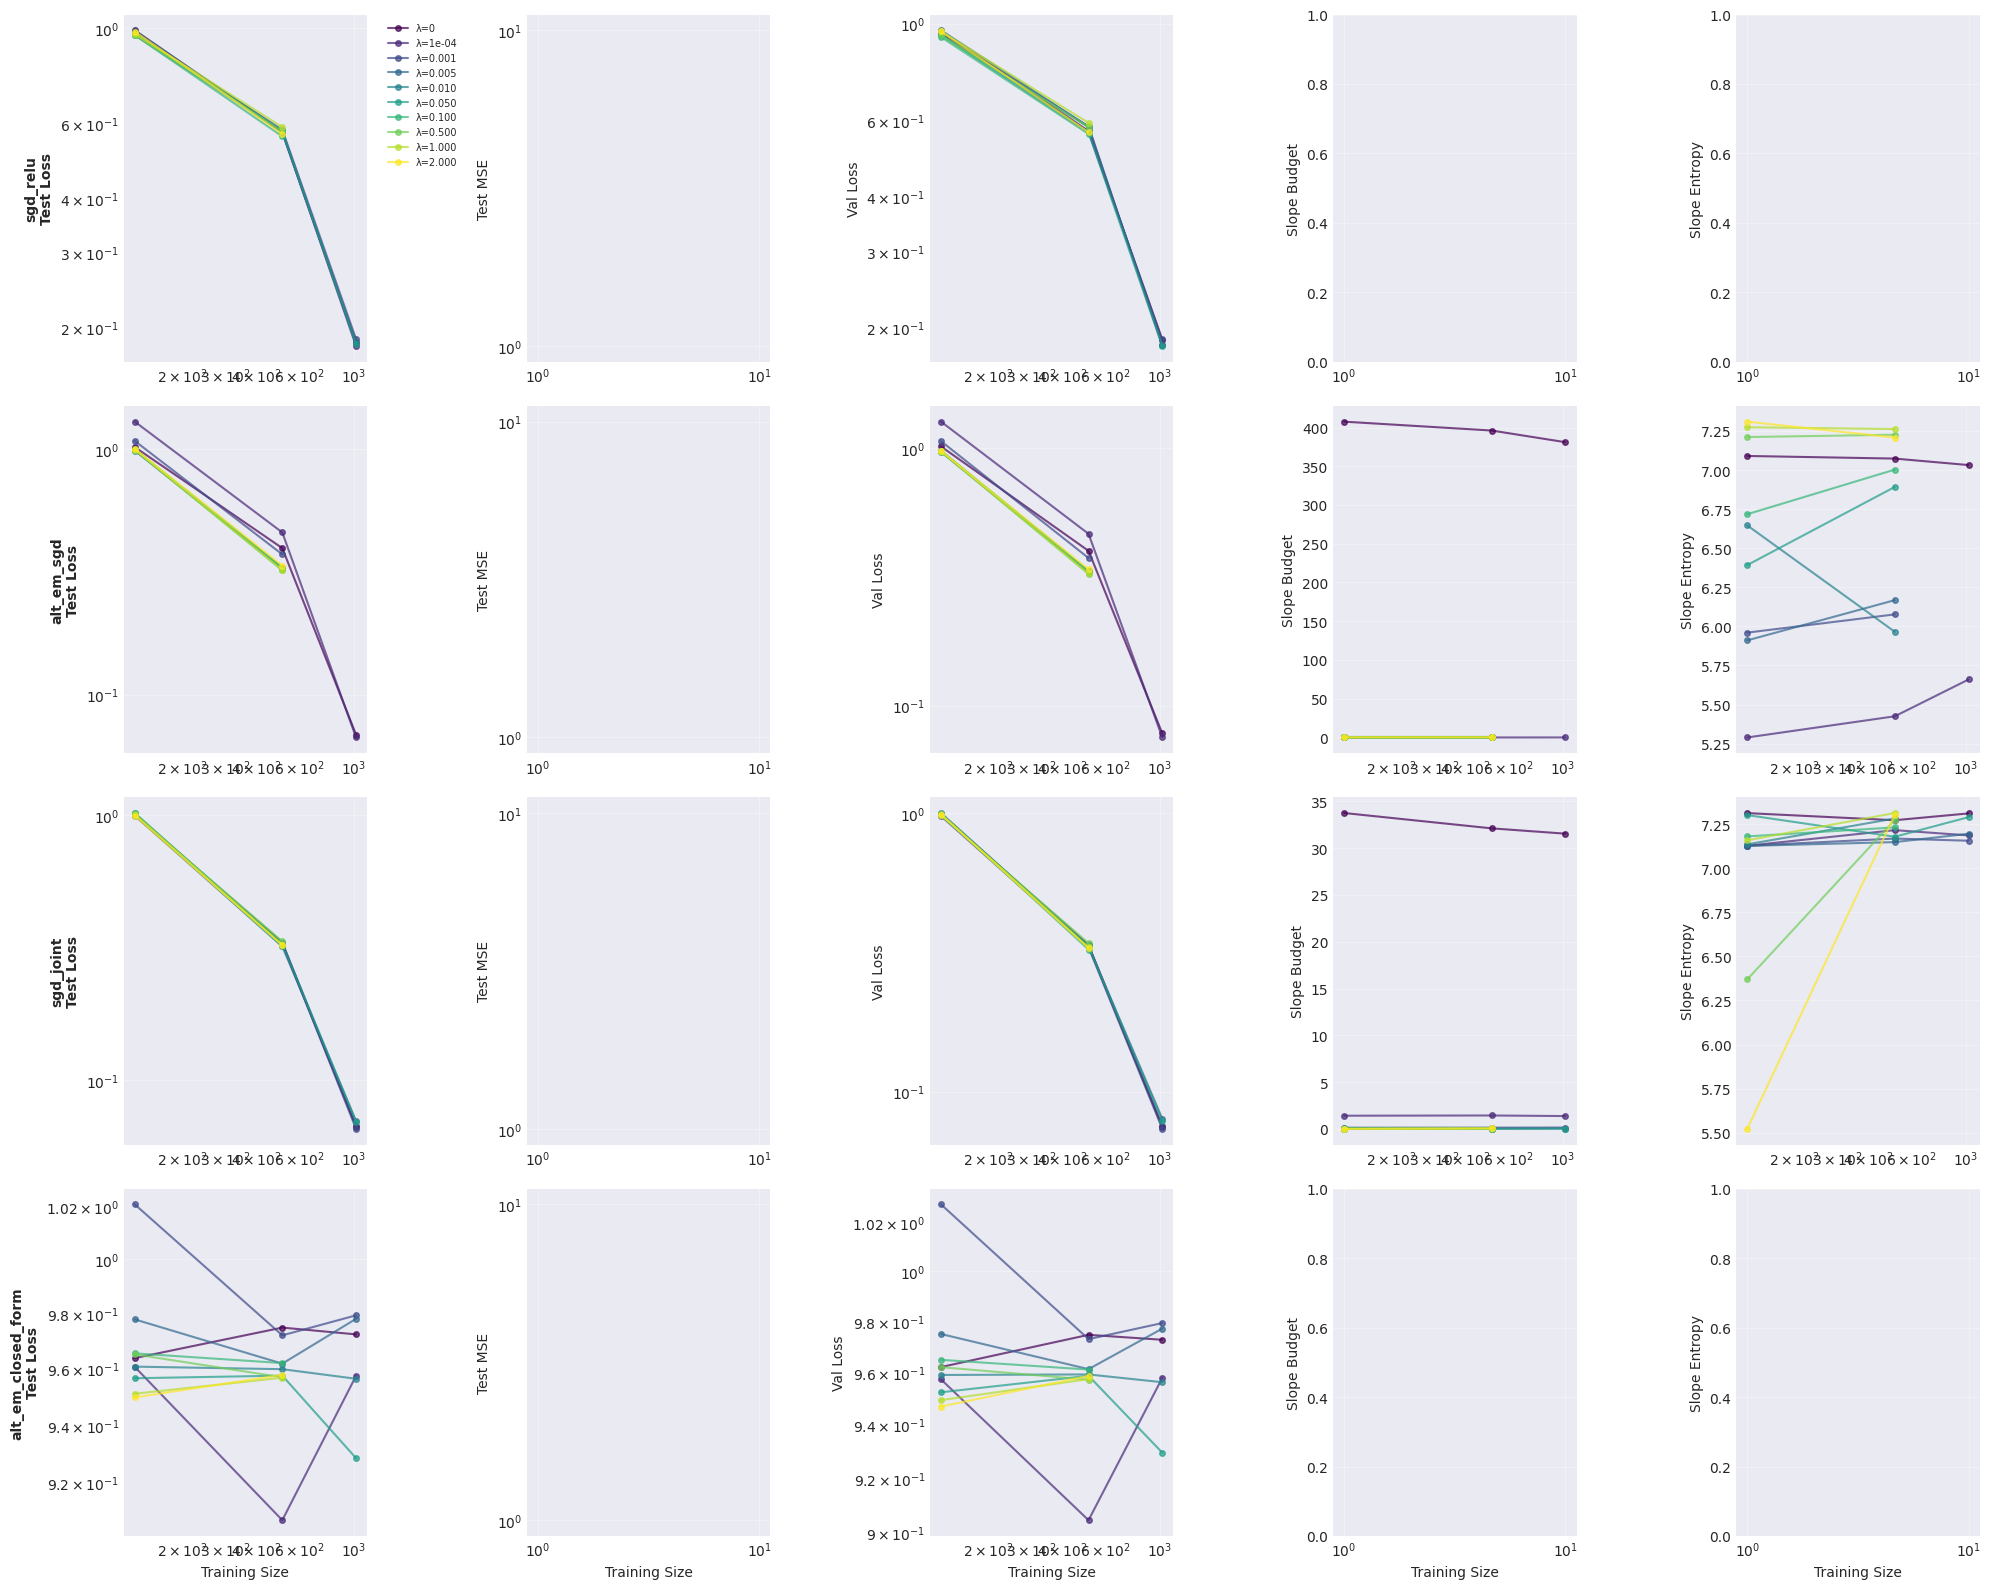

In [ ]:
# Create grid: rows = algorithms, cols = metrics
fig, axes = plt.subplots(n_algorithms, n_metrics, figsize=(4*n_metrics, 4*n_algorithms))

if n_algorithms == 1:
    axes = axes.reshape(1, -1)
if n_metrics == 1:
    axes = axes.reshape(-1, 1)

for algo_idx, algo in enumerate(algorithms):
    for metric_idx, (metric_key, metric_name, scale) in enumerate(metrics_to_plot):
        ax = axes[algo_idx, metric_idx]
        
        # Collect data for this metric
        for lam in all_lambdas:
            n_trains = []
            values = []
            
            for n_train in sorted(data[algo].keys()):
                if lam in data[algo][n_train]:
                    metrics = data[algo][n_train][lam]
                    if metric_key in metrics and metrics[metric_key] is not None:
                        n_trains.append(n_train)
                        values.append(metrics[metric_key])
            
            if n_trains:
                # Format lambda for label
                if lam == 0:
                    lam_label = '0'
                elif lam < 0.001:
                    lam_label = f'{lam:.0e}'
                else:
                    lam_label = f'{lam:.3f}'
                
                ax.plot(n_trains, values, 'o-', color=lambda_to_color[lam], 
                       label=f'λ={lam_label}', linewidth=1.5, markersize=4, alpha=0.7)
        
        # Set labels and scale
        if algo_idx == n_algorithms - 1:  # Bottom row
            ax.set_xlabel('Training Size', fontsize=10)
        if metric_idx == 0:  # Left column
            ax.set_ylabel(f'{algo}\n{metric_name}', fontsize=10, fontweight='bold')
        else:
            ax.set_ylabel(metric_name, fontsize=10)
        
        if scale == 'log':
            ax.set_xscale('log')
            ax.set_yscale('log')
        else:
            ax.set_xscale('log')
        
        ax.grid(True, alpha=0.3)
        
        # Add legend only to first subplot
        if algo_idx == 0 and metric_idx == 0:
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=7, ncol=1)

plt.tight_layout()
plt.savefig('all_metrics_grid.png', dpi=300, bbox_inches='tight')
plt.show()


## Plot 3: Slope Deviation per Layer (per algorithm)

## Plot 3: Slope Deviation per Layer (per algorithm)

In [ ]:
# Determine number of layers from data
n_layers = None
for algo in algorithms:
    for n_train in data[algo].values():
        for metrics in n_train.values():
            if 'final_slope_deviation_layers' in metrics and metrics['final_slope_deviation_layers'] is not None:
                n_layers = len(metrics['final_slope_deviation_layers'])
                break
        if n_layers is not None:
            break
    if n_layers is not None:
        break

if n_layers is None:
    print("Warning: No slope deviation layer data found")
else:
    print(f"Found {n_layers} layers in the data")


Found 3 layers in the data


Skipping sgd_relu: no slope deviation data


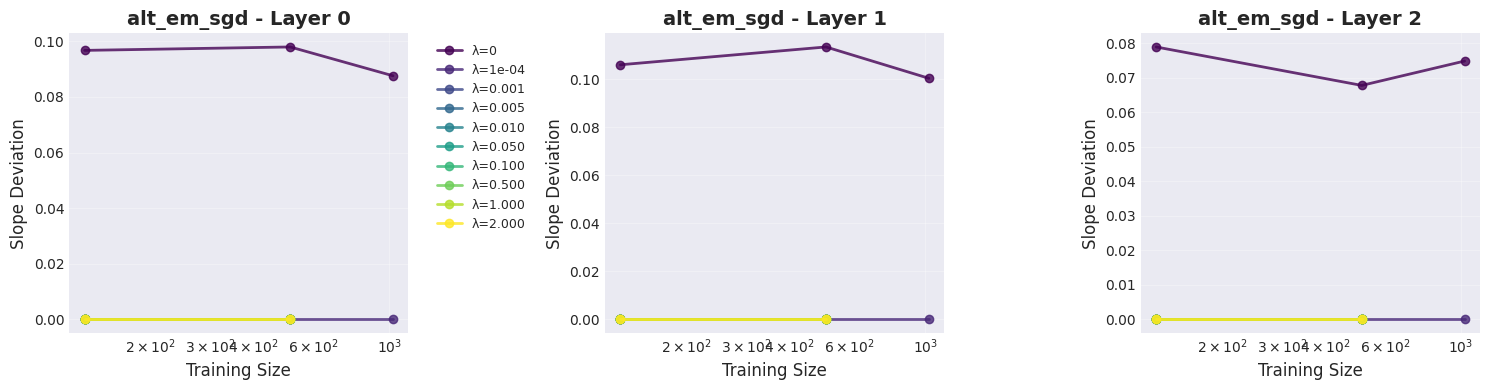

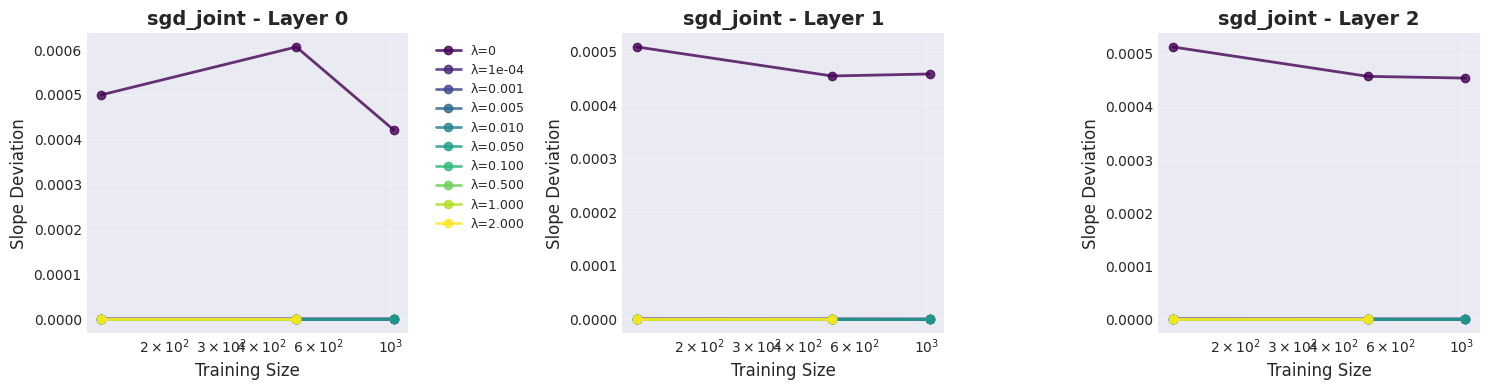

Skipping alt_em_closed_form: no slope deviation data


In [ ]:
# Plot slope deviation per layer for each algorithm
if n_layers is not None:
    for algo in algorithms:
        # Check if this algorithm has slope deviation data
        has_data = False
        for n_train in data[algo].values():
            for metrics in n_train.values():
                if 'final_slope_deviation_layers' in metrics and metrics['final_slope_deviation_layers'] is not None:
                    has_data = True
                    break
            if has_data:
                break
        
        if not has_data:
            print(f"Skipping {algo}: no slope deviation data")
            continue
        
        # Create figure with subplots for each layer
        fig, axes = plt.subplots(1, n_layers, figsize=(5*n_layers, 4))
        if n_layers == 1:
            axes = [axes]
        
        # Plot each layer
        for layer_idx in range(n_layers):
            ax = axes[layer_idx]
            
            # Collect data for this layer
            for lam in all_lambdas:
                n_trains = []
                deviations = []
                
                for n_train in sorted(data[algo].keys()):
                    if lam in data[algo][n_train]:
                        metrics = data[algo][n_train][lam]
                        if 'final_slope_deviation_layers' in metrics and metrics['final_slope_deviation_layers'] is not None:
                            layer_deviations = metrics['final_slope_deviation_layers']
                            if isinstance(layer_deviations, list) and layer_idx < len(layer_deviations):
                                n_trains.append(n_train)
                                deviations.append(layer_deviations[layer_idx])
                
                if n_trains:
                    # Format lambda for label
                    if lam == 0:
                        lam_label = '0'
                    elif lam < 0.001:
                        lam_label = f'{lam:.0e}'
                    else:
                        lam_label = f'{lam:.3f}'
                    
                    ax.plot(n_trains, deviations, 'o-', color=lambda_to_color[lam], 
                           label=f'λ={lam_label}', linewidth=2, markersize=6, alpha=0.8)
            
            # Set labels and scale
            ax.set_xlabel('Training Size', fontsize=12)
            ax.set_ylabel(f'Slope Deviation', fontsize=12)
            ax.set_title(f'{algo} - Layer {layer_idx}', fontsize=14, fontweight='bold')
            ax.set_xscale('log')
            ax.grid(True, alpha=0.3)
            
            # Add legend to first subplot
            if layer_idx == 0:
                ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9, ncol=1)
        
        plt.tight_layout()
        plt.savefig(f'slope_deviation_per_layer_{algo}.png', dpi=300, bbox_inches='tight')
        plt.show()
else:
    print("No layer data available for plotting")


## Plot 4: Mask Churn per Layer (per algorithm)


In [ ]:
# Determine number of layers from churn data (should be same as slope deviation)
n_layers_churn = None
for algo in algorithms:
    for n_train in data[algo].values():
        for metrics in n_train.values():
            if 'final_mask_churn_layers' in metrics and metrics['final_mask_churn_layers'] is not None:
                n_layers_churn = len(metrics['final_mask_churn_layers'])
                break
        if n_layers_churn is not None:
            break
    if n_layers_churn is not None:
        break

if n_layers_churn is None:
    print("Warning: No mask churn layer data found")
else:
    print(f"Found {n_layers_churn} layers in the churn data")


Found 3 layers in the churn data


Skipping sgd_relu: no mask churn data


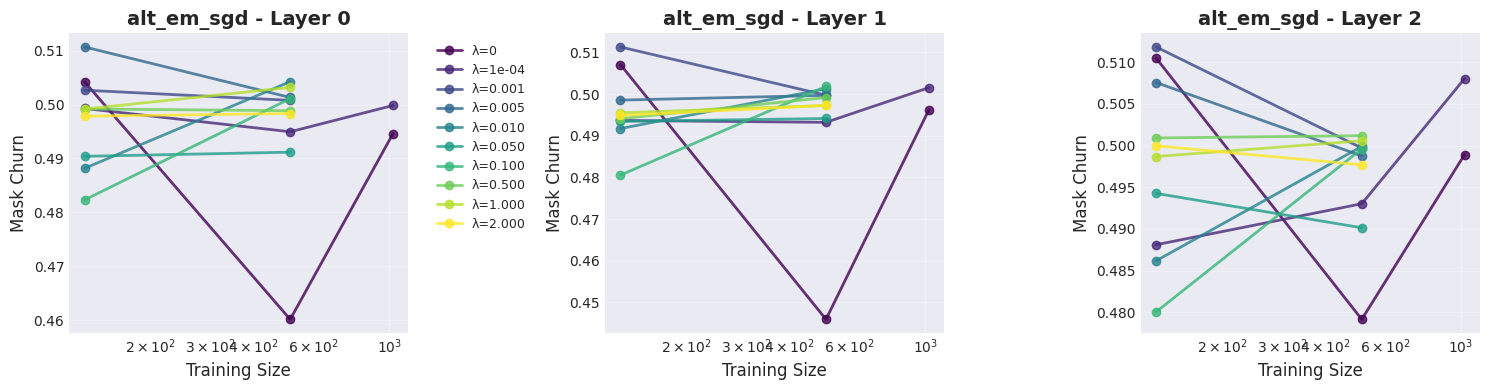

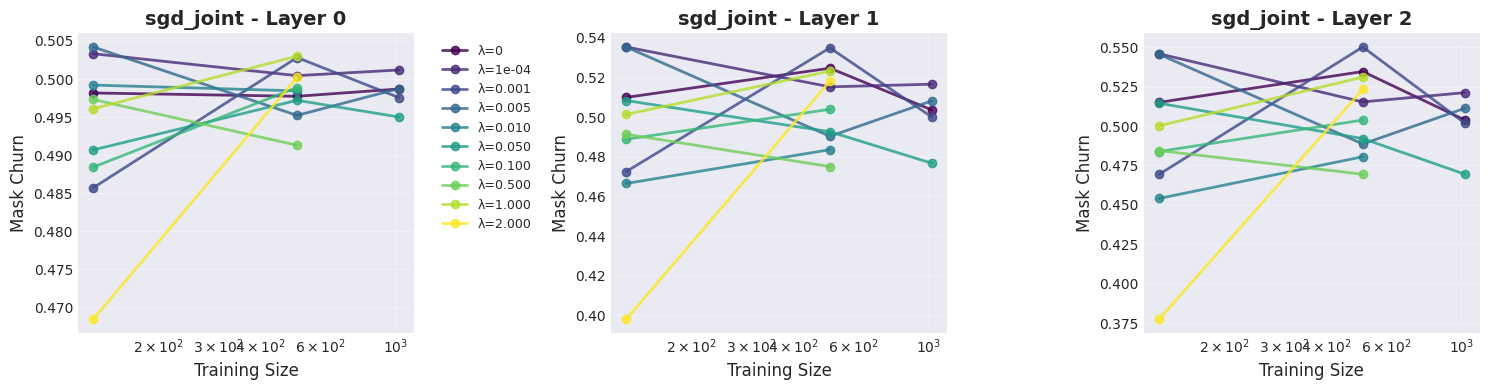

Skipping alt_em_closed_form: no mask churn data


In [ ]:
# Plot mask churn per layer for each algorithm
if n_layers_churn is not None:
    for algo in algorithms:
        # Check if this algorithm has churn data
        has_data = False
        for n_train in data[algo].values():
            for metrics in n_train.values():
                if 'final_mask_churn_layers' in metrics and metrics['final_mask_churn_layers'] is not None:
                    has_data = True
                    break
            if has_data:
                break
        
        if not has_data:
            print(f"Skipping {algo}: no mask churn data")
            continue
        
        # Create figure with subplots for each layer
        fig, axes = plt.subplots(1, n_layers_churn, figsize=(5*n_layers_churn, 4))
        if n_layers_churn == 1:
            axes = [axes]
        
        # Plot each layer
        for layer_idx in range(n_layers_churn):
            ax = axes[layer_idx]
            
            # Collect data for this layer
            for lam in all_lambdas:
                n_trains = []
                churns = []
                
                for n_train in sorted(data[algo].keys()):
                    if lam in data[algo][n_train]:
                        metrics = data[algo][n_train][lam]
                        if 'final_mask_churn_layers' in metrics and metrics['final_mask_churn_layers'] is not None:
                            layer_churns = metrics['final_mask_churn_layers']
                            if isinstance(layer_churns, list) and layer_idx < len(layer_churns):
                                n_trains.append(n_train)
                                churns.append(layer_churns[layer_idx])
                
                if n_trains:
                    # Format lambda for label
                    if lam == 0:
                        lam_label = '0'
                    elif lam < 0.001:
                        lam_label = f'{lam:.0e}'
                    else:
                        lam_label = f'{lam:.3f}'
                    
                    ax.plot(n_trains, churns, 'o-', color=lambda_to_color[lam], 
                           label=f'λ={lam_label}', linewidth=2, markersize=6, alpha=0.8)
            
            # Set labels and scale
            ax.set_xlabel('Training Size', fontsize=12)
            ax.set_ylabel(f'Mask Churn', fontsize=12)
            ax.set_title(f'{algo} - Layer {layer_idx}', fontsize=14, fontweight='bold')
            ax.set_xscale('log')
            ax.grid(True, alpha=0.3)
            
            # Add legend to first subplot
            if layer_idx == 0:
                ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9, ncol=1)
        
        plt.tight_layout()
        plt.savefig(f'mask_churn_per_layer_{algo}.png', dpi=300, bbox_inches='tight')
        plt.show()
else:
    print("No churn layer data available for plotting")


## Summary Statistics


In [ ]:
# Create summary DataFrame
summary_data = []

for algo in algorithms:
    for n_train in sorted(data[algo].keys()):
        for lam in sorted(data[algo][n_train].keys()):
            metrics = data[algo][n_train][lam]
            row = {
                'algorithm': algo,
                'n_train': n_train,
                'lambda': lam,
                'test_loss': metrics.get('test_loss', None),
                'train_loss': metrics.get('train_loss', None),
                'test_acc': metrics.get('test_acc', None),
                'train_acc': metrics.get('train_acc', None),
            }
            if 'final_slope_budget_total' in metrics:
                row['slope_budget'] = metrics.get('final_slope_budget_total')
            summary_data.append(row)

df_summary = pd.DataFrame(summary_data)
print(f"Summary DataFrame shape: {df_summary.shape}")
print("\nFirst few rows:")
print(df_summary.head(10))


Summary DataFrame shape: (98, 8)

First few rows:
  algorithm  n_train  lambda  test_loss    train_loss  test_acc  train_acc  \
0  sgd_relu      128  0.0000   0.986481  1.113859e-12    0.5962        1.0   
1  sgd_relu      128  0.0001   0.973345  6.502562e-10    0.5996        1.0   
2  sgd_relu      128  0.0010   0.967776  8.096673e-07    0.6062        1.0   
3  sgd_relu      128  0.0050   0.984577  1.965511e-12    0.5916        1.0   
4  sgd_relu      128  0.0100   0.961104  2.210371e-12    0.6008        1.0   
5  sgd_relu      128  0.0500   0.968477  5.522999e-09    0.6054        1.0   
6  sgd_relu      128  0.1000   0.961324  1.533024e-12    0.6016        1.0   
7  sgd_relu      128  0.5000   0.962660  1.093070e-12    0.6086        1.0   
8  sgd_relu      128  1.0000   0.967200  7.574363e-10    0.5980        1.0   
9  sgd_relu      128  2.0000   0.979447  2.323808e-12    0.5970        1.0   

   slope_budget  
0           NaN  
1           NaN  
2           NaN  
3           NaN  
4

In [ ]:
# Save summary to CSV
df_summary.to_csv('results_summary.csv', index=False)
print("Summary saved to results_summary.csv")


Summary saved to results_summary.csv


In [ ]:
import numpy as np
from numpy.fft import fft2, ifft2

class ScalarLatticeModel:
    def __init__(self, L, J=0.05, alpha=1.0, lambda_decay=2.0, R_c=10.0, seed=None):
        self.L = L
        self.N = L * L
        self.J = J
        self.alpha = alpha
        self.lambda_decay = lambda_decay
        self.R_c = R_c
        # Define states as a column vector for broadcasting later: shape (7, 1, 1)
        self.states = np.array([-3, -2, -1, 0, 1, 2, 3])
        self.states_view = self.states[:, None, None] 
        
        if seed is not None:
            np.random.seed(seed)
        
        # Initialize lattice randomly from the 7 states
        self.x = np.random.choice(self.states, size=(L, L))
        
        # Precompute interaction kernel
        self.w_kernel_fft = fft2(self._compute_interaction_kernel())
        
    def _compute_interaction_kernel(self):
        L = self.L
        # Create grid of coordinates (vectorized)
        x = np.arange(L)
        y = np.arange(L)
        X, Y = np.meshgrid(x, y, indexing='ij')
        
        # Minimum image distance (vectorized)
        dX = np.minimum(X, L - X)
        dY = np.minimum(Y, L - Y)
        R = np.sqrt(dX**2 + dY**2)
        
        # Calculate w based on conditions
        w = np.zeros((L, L))
        mask = (R > 0) & (R <= self.R_c)
        w[mask] = np.exp(-R[mask] / self.lambda_decay)
        return w
    
    def on_site_potential(self, u):
        return self.alpha * (u**4 - u**2)
    
    def compute_local_fields(self):
        """
        Computes field h_i for all i simultaneously via FFT.
        """
        x_fft = fft2(self.x)
        # Real part is taken because numerical noise might introduce tiny imaginary parts
        convolution = ifft2(self.w_kernel_fft * x_fft).real
        return self.J * convolution
    
    def heat_bath_sweep(self, beta):
        """
        Vectorized Heat-Bath Update.
        """
        L = self.L
        
        # 1. Compute local fields (L, L)
        h = self.compute_local_fields()
        
        # 2. Compute Energy for ALL 7 states at ALL sites simultaneously
        # V(u) shape: (7, 1, 1)
        # h shape: (L, L) -> broadcasts to (1, L, L)
        # Result E shape: (7, L, L)
        E = self.on_site_potential(self.states_view) - h[None, :, :] * self.states_view
        
        # 3. Compute Boltzmann Probabilities
        # Subtract min energy for numerical stability (avoids overflow in exp)
        E_min = np.min(E, axis=0, keepdims=True)
        probs = np.exp(-beta * (E - E_min))
        
        # Normalize (sum over the 7 states, axis 0)
        Z = np.sum(probs, axis=0, keepdims=True)
        probs /= Z  # Shape (7, L, L)
        
        # 4. Vectorized Random Sampling (Custom Implementation)
        # numpy.random.choice cannot handle different probabilities per pixel efficiently.
        # We use the Cumulative Sum method.
        cum_probs = np.cumsum(probs, axis=0)
        
        # Generate random numbers for every site
        r = np.random.random((1, L, L))
        
        # Find the first state index where cum_probs > r
        # argmax returns the first index of the True value
        state_indices = np.argmax(cum_probs > r, axis=0)
        
        # Update grid
        self.x = self.states[state_indices]

    def magnetization(self):
        return np.mean(self.x)

# --- Simulation Loop ---

def run_annealing_simulation():
    # Fixed Parameters
    L = 64
    T_range = np.linspace(2.0, 0.01, 15)
    n_equil = 2000
    n_meas = 3000
    
    T_star_estimates = []
    
    # Run 3 independent seeds
    for run_idx in range(3):
        seed = 42 + run_idx * 1000
        model = ScalarLatticeModel(L=L, seed=seed)
        
        chi_list = []
        
        # Annealing loop: Temperature goes High -> Low
        for T in T_range:
            beta = 1.0 / T
            
            # Equilibration
            for _ in range(n_equil):
                model.heat_bath_sweep(beta)
            
            # Measurement
            M_samples = np.zeros(n_meas)
            for k in range(n_meas):
                model.heat_bath_sweep(beta)
                M_samples[k] = model.magnetization()
            
            # Calculate Chi
            m_mean = np.mean(M_samples)
            m2_mean = np.mean(M_samples**2)
            chi = (model.N / T) * (m2_mean - m_mean**2)
            chi_list.append(chi)
        
        # Find Peak
        chi_arr = np.array(chi_list)
        idx_max = np.argmax(chi_arr)
        T_star = T_range[idx_max]
        T_star_estimates.append(T_star)

    # Final Output Calculation
    avg_T_star = np.mean(T_star_estimates)
    
    # STRICT FORMATTING: Print ONLY the scalar value
    print(f"{avg_T_star:.1f}")

if __name__ == "__main__":
    run_annealing_simulation()

0.8


In [ ]:
import numpy as np

def make_kernel(L, lam, Rc):
    y = np.arange(L)
    x = np.arange(L)
    dy = np.minimum(y, L - y)[:, None]
    dx = np.minimum(x, L - x)[None, :]
    r = np.hypot(dy, dx)
    w = np.exp(-r / lam) * ((r > 0) & (r <= Rc))
    return w.astype(np.float64)

def run_schedule(seed, L=64, J=0.05, alpha=1.0, lam=2.0, Rc=10.0,
                 T_range=np.linspace(2.0, 0.01, 15),
                 N_eq=2000, N_meas=3000):
    rng = np.random.default_rng(seed)
    N = L * L

    # States and on-site potential
    Svals = np.array([-3, -2, -1, 0, 1, 2, 3], dtype=np.float64)
    Vvals = alpha * (Svals**4 - Svals**2)  # shape (7,)

    # Kernel and its FFT
    w = make_kernel(L, lam, Rc)
    Wk = np.fft.fft2(w)

    # Initial configuration (uniform over states)
    x = rng.choice(Svals, size=(L, L)).astype(np.float64)

    chis = np.empty(len(T_range), dtype=np.float64)

    for ti, T in enumerate(T_range):
        beta = 1.0 / T
        sumM = 0.0
        sumM2 = 0.0

        for s in range(N_eq + N_meas):
            # Field via circular convolution
            Xk = np.fft.fft2(x)
            h = J * np.fft.ifft2(Wk * Xk).real  # shape (L,L)

            # Heat-bath update (synchronous)
            # energies[u, i, j] = V(u) - h[i,j]*u
            energies = Vvals[:, None, None] - h[None, :, :] * Svals[:, None, None]
            E_min = energies.min(axis=0)
            weights = np.exp(-beta * (energies - E_min))
            Z = weights.sum(axis=0)
            probs = weights / Z

            # Sample from categorical per site
            r = rng.random((L, L))
            cdf = probs.cumsum(axis=0)
            cdf[-1, :, :] = 1.0  # guard against roundoff
            idx = np.argmax(cdf >= r, axis=0)
            x = Svals[idx]

            if s >= N_eq:
                M = float(x.sum())
                sumM += M
                sumM2 += M * M

        meanM = sumM / N_meas
        meanM2 = sumM2 / N_meas
        chis[ti] = (meanM2 - meanM * meanM) / (N * T)

    T_star = float(T_range[np.argmax(chis)])
    return T_star

def main():
    seeds = [12345, 67890, 54321]
    Tstars = [run_schedule(seed) for seed in seeds]
    avg_Tstar = float(np.mean(Tstars))
    print(f"{avg_Tstar:.1f}")

if __name__ == "__main__":
    main()

0.8


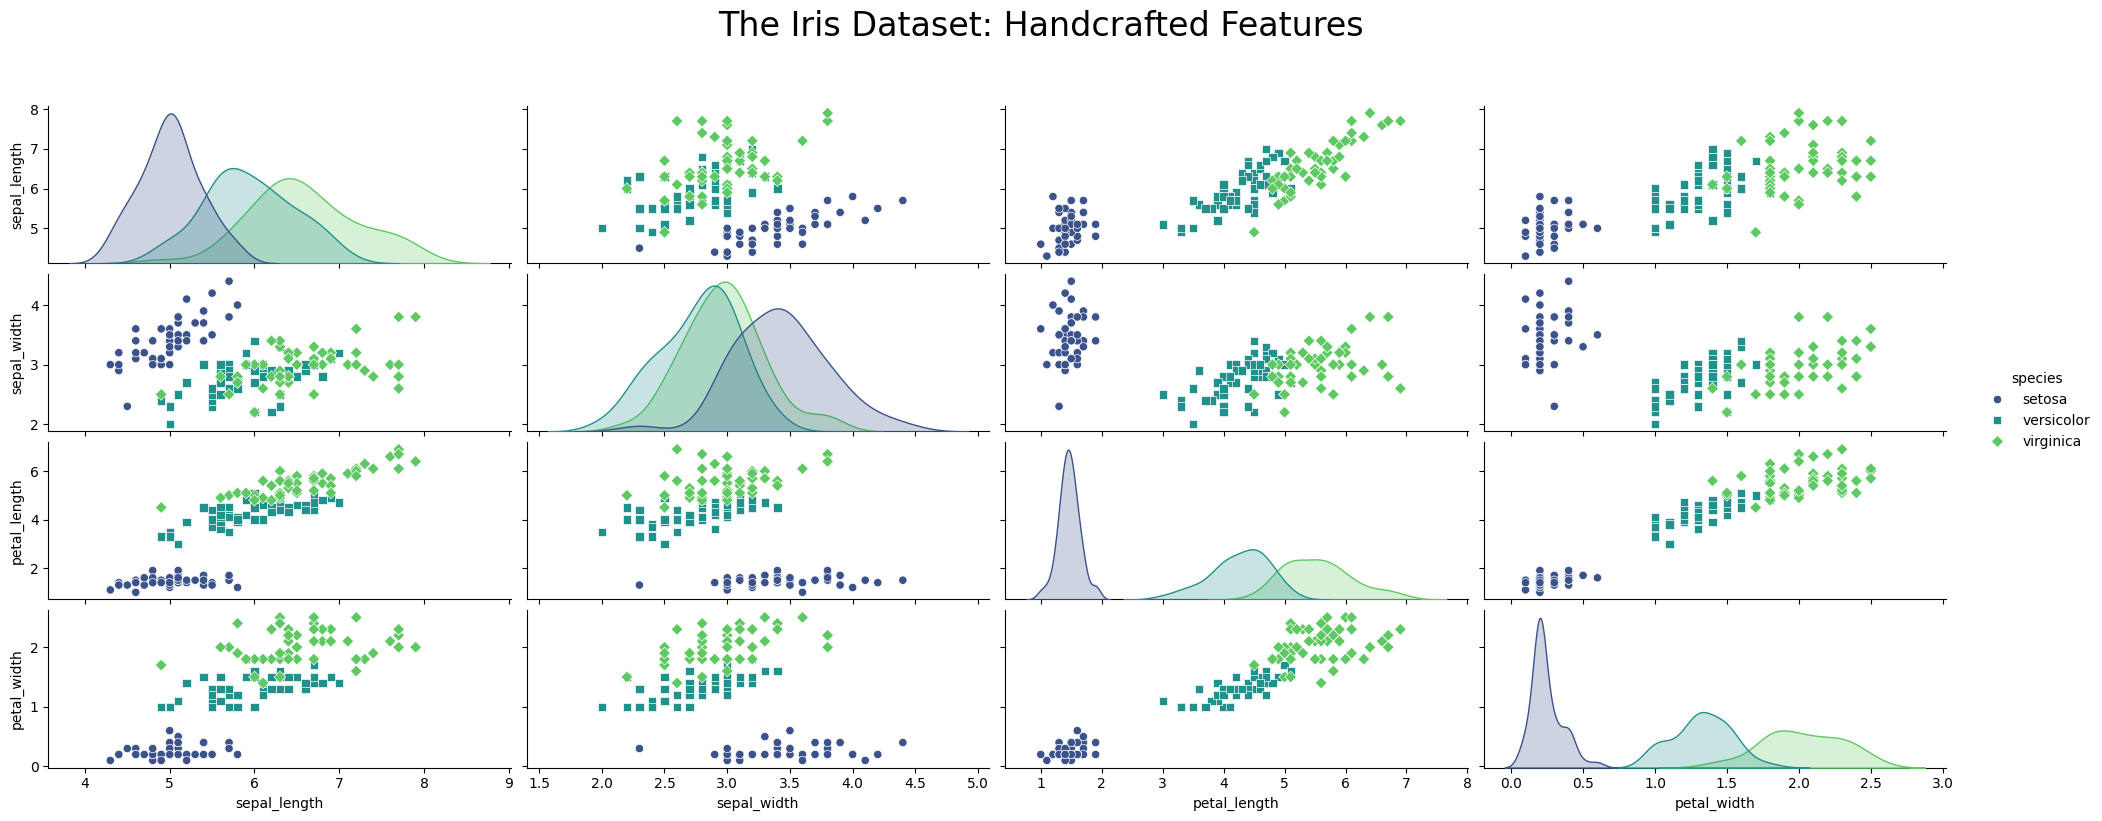

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load Data
df = sns.load_dataset('iris')

# 2. Create Plot
# ADAPT SIZE HERE:
# 'height': Height (in inches) of each individual square subplot.
# 'aspect': Ratio of width to height (width = height * aspect).
# For 16:9 slides, an aspect > 1 (rectangular subplots) works best.
g = sns.pairplot(
    df, 
    hue='species', 
    palette='viridis', 
    markers=["o", "s", "D"],
    height=2,    # Increase this to make the whole chart bigger
    aspect=2.5     # Increase this to make it wider (1.77 is true 16:9)
)

# 3. Title and Spacing
g.fig.suptitle("The Iris Dataset: Handcrafted Features", y=1.02, fontsize=24)
plt.subplots_adjust(top=0.9)

# 4. Save
# ADAPT RESOLUTION HERE:
# Change dpi to 300 or 600 for very high quality printing/projection
plt.savefig('iris_presentation.png', dpi=300, bbox_inches='tight')

plt.show()

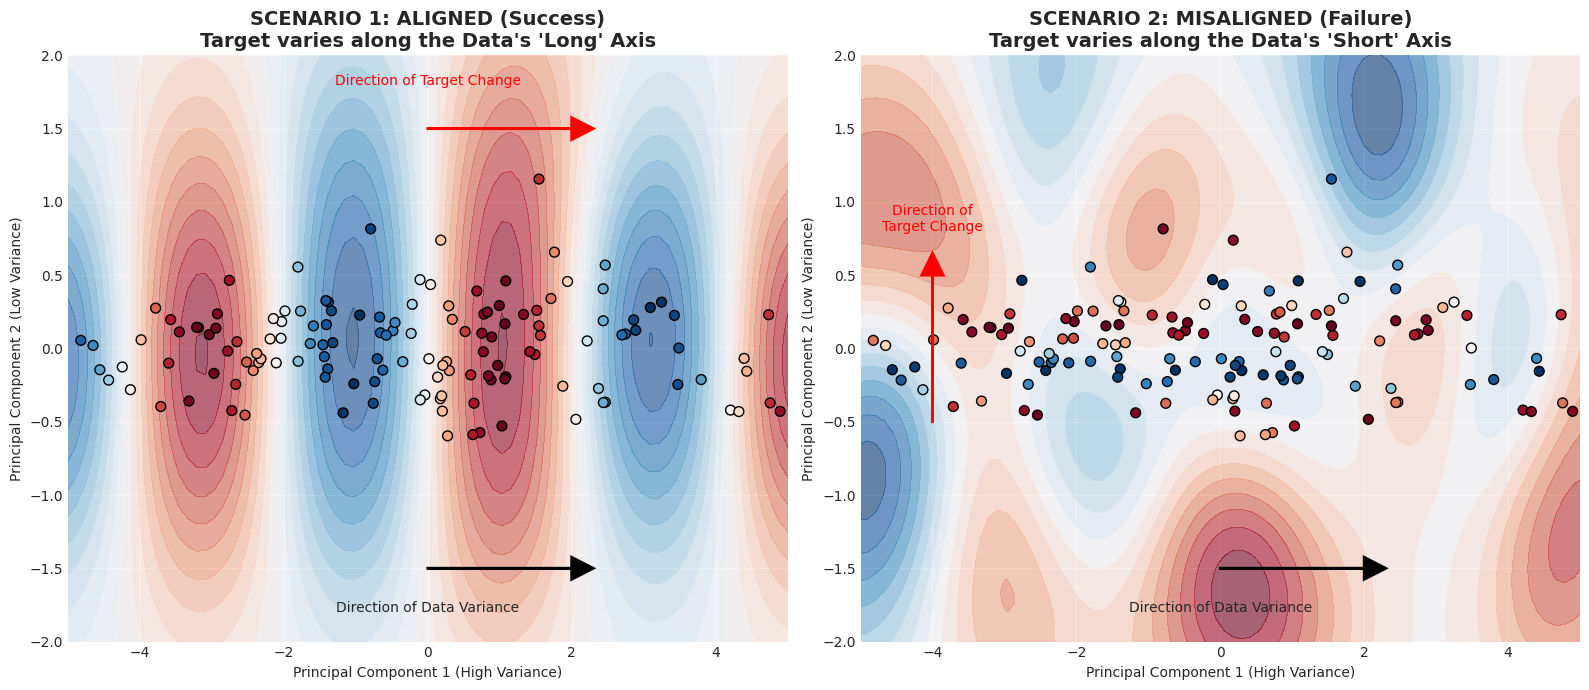

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.kernel_ridge import KernelRidge

# 1. Setup
np.random.seed(42)
n_samples = 150

# 2. Generate Anisotropic Data (The "Pancake")
# High variance in x (scale=3.0), Low variance in y (scale=0.3)
X = np.random.normal(0, 1, (n_samples, 2))
X[:, 0] = X[:, 0] * 3.0  # Stretch horizontally
X[:, 1] = X[:, 1] * 0.3  # Shrink vertically

# Define grid for plotting the "Learned Function"
xx, yy = np.meshgrid(np.linspace(-6, 6, 100), np.linspace(-3, 3, 100))
X_grid = np.c_[xx.ravel(), yy.ravel()]

# --- Scenario A: ALIGNED (Target changes along the High Variance axis) ---
# Target depends on x[0] (Horizontal)
y_aligned = np.sin(X[:, 0] * 1.5)
# Fit Kernel
model_aligned = KernelRidge(kernel='rbf', gamma=0.5, alpha=0.1)
model_aligned.fit(X, y_aligned)
Z_aligned = model_aligned.predict(X_grid).reshape(xx.shape)

# --- Scenario B: MISALIGNED (Target changes along the Low Variance axis) ---
# Target depends on x[1] (Vertical)
# Note: We make the frequency similar relative to the scale to show the difficulty
y_misaligned = np.sin(X[:, 1] * 10.0) 
# Fit Kernel
model_misaligned = KernelRidge(kernel='rbf', gamma=0.5, alpha=0.1)
model_misaligned.fit(X, y_misaligned)
Z_misaligned = model_misaligned.predict(X_grid).reshape(xx.shape)

# 3. Plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Plot A: Aligned
ax1 = axes[0]
contour1 = ax1.contourf(xx, yy, Z_aligned, cmap='RdBu_r', alpha=0.6, levels=20)
ax1.scatter(X[:, 0], X[:, 1], c=y_aligned, cmap='RdBu_r', edgecolors='k', s=50)
ax1.set_title("SCENARIO 1: ALIGNED (Success)\nTarget varies along the Data's 'Long' Axis", fontsize=14, fontweight='bold')
ax1.set_xlabel("Principal Component 1 (High Variance)")
ax1.set_ylabel("Principal Component 2 (Low Variance)")
ax1.set_xlim(-5, 5)
ax1.set_ylim(-2, 2)

# Add arrows to show alignment
ax1.arrow(0, -1.5, 2, 0, head_width=0.15, head_length=0.3, fc='k', ec='k', linewidth=2)
ax1.text(0, -1.8, "Direction of Data Variance", ha='center', fontsize=10)
ax1.arrow(0, 1.5, 2, 0, head_width=0.15, head_length=0.3, fc='red', ec='red', linewidth=2)
ax1.text(0, 1.8, "Direction of Target Change", ha='center', color='red', fontsize=10)


# Plot B: Misaligned
ax2 = axes[1]
contour2 = ax2.contourf(xx, yy, Z_misaligned, cmap='RdBu_r', alpha=0.6, levels=20)
ax2.scatter(X[:, 0], X[:, 1], c=y_misaligned, cmap='RdBu_r', edgecolors='k', s=50)
ax2.set_title("SCENARIO 2: MISALIGNED (Failure)\nTarget varies along the Data's 'Short' Axis", fontsize=14, fontweight='bold')
ax2.set_xlabel("Principal Component 1 (High Variance)")
ax2.set_ylabel("Principal Component 2 (Low Variance)")
ax2.set_xlim(-5, 5)
ax2.set_ylim(-2, 2)

# Add arrows to show misalignment
ax2.arrow(0, -1.5, 2, 0, head_width=0.15, head_length=0.3, fc='k', ec='k', linewidth=2)
ax2.text(0, -1.8, "Direction of Data Variance", ha='center', fontsize=10)
ax2.arrow(-4, -0.5, 0, 1.0, head_width=0.3, head_length=0.15, fc='red', ec='red', linewidth=2)
ax2.text(-4, 0.8, "Direction of\nTarget Change", ha='center', color='red', fontsize=10)

plt.tight_layout()
plt.show()